## CSAI: Assignment-5
#### Akshit Sharma (2021101029)

In [277]:
from transformers import BertTokenizer,BertModel
import numpy as np
from nltk.tokenize import RegexpTokenizer
from sklearn.linear_model import Ridge
import torch
from scipy.spatial.distance import cosine
import spacy
import matplotlib.pyplot as plt

### Loading sentences from text stimuli file

In [278]:
with open('./data/stimuli.txt', 'r') as file:
    stimuli=file.readlines()
stimuli=[s[:-1] if s[-1]=='\n' else s for s in stimuli]

### Code to get BERT embeddings (both pooled and CLS)

In [279]:
def extract_bert_sentence_embedding(sentence):
    model_name = 'bert-base-uncased'
    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertModel.from_pretrained(model_name)
    tokens = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True)
    outputs = model(**tokens)
    cls_embedding = outputs.last_hidden_state[:, 0, :].detach().numpy().squeeze()
    hidden_states = outputs.last_hidden_state
    pooled_embedding = hidden_states[:, 1:-1, :].mean(dim=1)
    pooled_embedding = pooled_embedding.detach().numpy().squeeze()
    return cls_embedding,pooled_embedding
bert_embeddings_cls=[]
bert_embeddings_pooled=[]
for s in stimuli:
    cls_embedding, pooled_embedding = extract_bert_sentence_embedding(s)
    bert_embeddings_cls.append(cls_embedding)
    bert_embeddings_pooled.append(pooled_embedding)
bert_embeddings_cls=np.array(bert_embeddings_cls)
bert_embeddings_pooled=np.array(bert_embeddings_pooled)

### Code to get Glove Embeddings from downloaded glove.6B.300d.txt file

In [280]:
glove_embeddings=[]
def load_glove_embeddings(embeddings_file):
    word_to_index = {}
    embeddings = []
    with open(embeddings_file, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            values = line.split()
            word = values[0]
            embedding = np.array(values[1:], dtype='float32')
            word_to_index[word] = i
            embeddings.append(embedding)
    embeddings = np.array(embeddings)
    return word_to_index, embeddings

def generate_sentence_embeddings(sentence, word_to_index, embeddings):
    tokenizer = RegexpTokenizer(r'\w+|[^\w\s]')
    words = tokenizer.tokenize(sentence.lower())
    sentence_embedding = np.zeros(embeddings.shape[1])
    for word in words:
        if word in word_to_index:
            word_index = word_to_index[word]
            word_embedding = embeddings[word_index]
            sentence_embedding += word_embedding
    
    return sentence_embedding/len(words)
glove_embeddings=[]
glove_file = "data/glove.6B.300d.txt"
word_to_index, embeddings = load_glove_embeddings(glove_file)
for sentence in stimuli:
    sentence_embedding = generate_sentence_embeddings(sentence, word_to_index, embeddings)
    glove_embeddings.append(sentence_embedding)
glove_embeddings=np.array(glove_embeddings)

### Encoder and Decoder function (takes different embeddings, ROI data as input)

In [282]:
def encode_decode(n, k, voxel_data, embeddings, ROI, type_embed, sub, lst_2v2_enc, lst_pc_enc, lst_2v2_dec, lst_pc_dec):
    fold_size = n // k
    twov2_lst = []
    pc_lst = []
    for i in range(k):
        start = i * fold_size
        end = (i + 1) * fold_size if i < k - 1 else n
        val_indices = list(range(start, end))
        train_indices = list(range(0, start)) + list(range(end, n))
        X_train = embeddings[train_indices]
        y_train = voxel_data[train_indices]
        X_val = embeddings[val_indices]
        y_val = voxel_data[val_indices]
        model=Ridge()
        model.fit(X_train, y_train)
        pred=model.predict(X_val)
        samples=pred.shape[0]
        twov2acc=0
        for i in range(samples-1):
            for j in range(i+1,samples):
                twov2acc+=int((cosine(y_val[i],pred[i])+cosine(y_val[j],pred[j]))<(cosine(y_val[i],pred[j])+cosine(y_val[j],pred[i])))
        twov2acc/=((samples*(samples-1))/2)
        pc=0
        for i in range(samples):
            pc+=np.corrcoef(y_val[i],pred[i])[0,1]
        pc/=samples
        twov2_lst.append(twov2acc)
        pc_lst.append(pc)
    print(f"Subject-{sub}")
    print('Encoding brain voxels...')
    print(f'ROI: {ROI}, Embeddings: {type_embed}')
    print(f'2V2Acc: {np.average(twov2_lst)}')
    print(f'PC: {np.average(pc_lst)}')
    lst_2v2_enc.append(np.average(twov2_lst))
    lst_pc_enc.append(np.average(pc_lst))

    # Brain decoder
    fold_size = n // k
    twov2_lst = []
    pc_lst = []
    for i in range(k):
        start = i * fold_size
        end = (i + 1) * fold_size if i < k - 1 else n
        val_indices = list(range(start, end))
        train_indices = list(range(0, start)) + list(range(end, n))
        y_train = embeddings[train_indices]
        X_train = voxel_data[train_indices]
        y_val = embeddings[val_indices]
        X_val = voxel_data[val_indices]
        model=Ridge(alpha=1.0)
        model.fit(X_train, y_train)
        pred=model.predict(X_val)
        samples=pred.shape[0]
        twov2acc=0
        for i in range(samples-1):
            for j in range(i+1,samples):
                twov2acc+=int((cosine(y_val[i],pred[i])+cosine(y_val[j],pred[j]))<(cosine(y_val[i],pred[j])+cosine(y_val[j],pred[i])))
        twov2acc/=((samples*(samples-1))/2)
        pc=0
        for i in range(samples):
            pc+=np.corrcoef(y_val[i],pred[i])[0,1]
        pc/=samples
        twov2_lst.append(twov2acc)
        pc_lst.append(pc)
    print()
    print(f"Subject-{sub}")
    print('Decoding sentence representations...')
    print(f'ROI: {ROI}, Embeddings: {type_embed}')
    print(f'2V2Acc: {np.average(twov2_lst)}')
    print(f'PC: {np.average(pc_lst)}')
    lst_2v2_dec.append(np.average(twov2_lst))
    lst_pc_dec.append(np.average(pc_lst))
bert_embeddings_pooled=np.array(bert_embeddings_pooled)

## Subject-1

In [283]:
subj1_data=np.load('data/subj1.npy', allow_pickle=True).item()
subj1_language=subj1_data['language']
subj1_vision=subj1_data['vision']
subj1_task=subj1_data['task']
subj1_dmn=subj1_data['dmn']
subj1_2v2_lst_enc=[]
subj1_2v2_lst_dec=[]
subj1_pc_lst_enc=[]
subj1_pc_lst_dec=[]
k=5

### ROI: Language

#### BERT (CLS)

In [284]:
encode_decode(glove_embeddings.shape[0],k,subj1_language,bert_embeddings_cls,'Language','BERT (CLS)',1,subj1_2v2_lst_enc,subj1_pc_lst_enc,subj1_2v2_lst_dec,subj1_pc_lst_dec)

Subject-1
Encoding brain voxels...
ROI: Language, Embeddings: BERT (CLS)
2V2Acc: 0.669390093980188
PC: 0.5876767825179222

Subject-1
Decoding sentence representations...
ROI: Language, Embeddings: BERT (CLS)
2V2Acc: 0.8534219351613306
PC: 0.8073537485385588


#### BERT (Pooled)

In [285]:
encode_decode(glove_embeddings.shape[0],k,subj1_language,bert_embeddings_pooled,'Language','BERT (Pooled)',1,subj1_2v2_lst_enc,subj1_pc_lst_enc,subj1_2v2_lst_dec,subj1_pc_lst_dec)

Subject-1
Encoding brain voxels...
ROI: Language, Embeddings: BERT (Pooled)
2V2Acc: 0.6896180138772976
PC: 0.6001049918925523

Subject-1
Decoding sentence representations...
ROI: Language, Embeddings: BERT (Pooled)
2V2Acc: 0.9178845515278333
PC: 0.6740001387652962


#### GloVe

In [286]:
encode_decode(glove_embeddings.shape[0],k,subj1_language,glove_embeddings,'Language','GloVe',1,subj1_2v2_lst_enc,subj1_pc_lst_enc,subj1_2v2_lst_dec,subj1_pc_lst_dec)

Subject-1
Encoding brain voxels...
ROI: Language, Embeddings: GloVe
2V2Acc: 0.7204834589224735
PC: 0.7171799754249375

Subject-1
Decoding sentence representations...
ROI: Language, Embeddings: GloVe
2V2Acc: 0.9121447948038753
PC: 0.802847455280251


### ROI: Vision

#### BERT (CLS)

In [287]:
encode_decode(glove_embeddings.shape[0],k,subj1_vision,bert_embeddings_cls,'Vision','BERT (CLS)',1,subj1_2v2_lst_enc,subj1_pc_lst_enc,subj1_2v2_lst_dec,subj1_pc_lst_dec)

Subject-1
Encoding brain voxels...
ROI: Vision, Embeddings: BERT (CLS)
2V2Acc: 0.6563017751813282
PC: 0.6534828339380845

Subject-1
Decoding sentence representations...
ROI: Vision, Embeddings: BERT (CLS)
2V2Acc: 0.8267690183888303
PC: 0.8126915507410232


#### BERT (Pooled)

In [288]:
encode_decode(glove_embeddings.shape[0],k,subj1_vision,bert_embeddings_pooled,'Vision','BERT (Pooled)',1,subj1_2v2_lst_enc,subj1_pc_lst_enc,subj1_2v2_lst_dec,subj1_pc_lst_dec)

Subject-1
Encoding brain voxels...
ROI: Vision, Embeddings: BERT (Pooled)
2V2Acc: 0.6686038761283871
PC: 0.66659202164575

Subject-1
Decoding sentence representations...
ROI: Vision, Embeddings: BERT (Pooled)
2V2Acc: 0.9196964701992896
PC: 0.6871601473850311


#### GloVe

In [289]:
encode_decode(glove_embeddings.shape[0],k,subj1_vision,glove_embeddings,'Vision','GloVe',1,subj1_2v2_lst_enc,subj1_pc_lst_enc,subj1_2v2_lst_dec,subj1_pc_lst_dec)

Subject-1
Encoding brain voxels...
ROI: Vision, Embeddings: GloVe
2V2Acc: 0.6956344747229177
PC: 0.763928032237687

Subject-1
Decoding sentence representations...
ROI: Vision, Embeddings: GloVe
2V2Acc: 0.9171274590676164
PC: 0.8115104078510577


### ROI: Task Positive

#### BERT (CLS)

In [290]:
encode_decode(glove_embeddings.shape[0],k,subj1_task,bert_embeddings_cls,'Task Positive','BERT (CLS)',1,subj1_2v2_lst_enc,subj1_pc_lst_enc,subj1_2v2_lst_dec,subj1_pc_lst_dec)

Subject-1
Encoding brain voxels...
ROI: Task Positive, Embeddings: BERT (CLS)
2V2Acc: 0.5933793501618749
PC: 0.35490704099782777

Subject-1
Decoding sentence representations...
ROI: Task Positive, Embeddings: BERT (CLS)
2V2Acc: 0.8129899827037749
PC: 0.8315402799574422


#### BERT (Pooled)

In [291]:
encode_decode(glove_embeddings.shape[0],k,subj1_task,bert_embeddings_pooled,'Task Positive','BERT (Pooled)',1,subj1_2v2_lst_enc,subj1_pc_lst_enc,subj1_2v2_lst_dec,subj1_pc_lst_dec)

Subject-1
Encoding brain voxels...
ROI: Task Positive, Embeddings: BERT (Pooled)
2V2Acc: 0.6150029375360337
PC: 0.37684901962806017

Subject-1
Decoding sentence representations...
ROI: Task Positive, Embeddings: BERT (Pooled)
2V2Acc: 0.8987382738448018
PC: 0.713154527274083


#### GloVe

In [292]:
encode_decode(glove_embeddings.shape[0],k,subj1_task,glove_embeddings,'Task Positive','GloVe',1,subj1_2v2_lst_enc,subj1_pc_lst_enc,subj1_2v2_lst_dec,subj1_pc_lst_dec)

Subject-1
Encoding brain voxels...
ROI: Task Positive, Embeddings: GloVe
2V2Acc: 0.634203756788466
PC: 0.511432201786848

Subject-1
Decoding sentence representations...
ROI: Task Positive, Embeddings: GloVe
2V2Acc: 0.8816368921626733
PC: 0.8264067589164668


### ROI: DMN

#### BERT (CLS)

In [293]:
encode_decode(glove_embeddings.shape[0],k,subj1_dmn,bert_embeddings_cls,'DMN','BERT (CLS)',1,subj1_2v2_lst_enc,subj1_pc_lst_enc,subj1_2v2_lst_dec,subj1_pc_lst_dec)

Subject-1
Encoding brain voxels...
ROI: DMN, Embeddings: BERT (CLS)
2V2Acc: 0.6016106986626671
PC: 0.3540640403155978

Subject-1
Decoding sentence representations...
ROI: DMN, Embeddings: BERT (CLS)
2V2Acc: 0.8327209131116675
PC: 0.8170873377671898


#### BERT (Pooled)

In [294]:
encode_decode(glove_embeddings.shape[0],k,subj1_dmn,bert_embeddings_pooled,'DMN','BERT (Pooled)',1,subj1_2v2_lst_enc,subj1_pc_lst_enc,subj1_2v2_lst_dec,subj1_pc_lst_dec)

Subject-1
Encoding brain voxels...
ROI: DMN, Embeddings: BERT (Pooled)
2V2Acc: 0.6149106555228984
PC: 0.36130892188944563

Subject-1
Decoding sentence representations...
ROI: DMN, Embeddings: BERT (Pooled)
2V2Acc: 0.8969924598134911
PC: 0.6866403592440627


#### GloVe

In [295]:
encode_decode(glove_embeddings.shape[0],k,subj1_dmn,glove_embeddings,'DMN','GloVe',1,subj1_2v2_lst_enc,subj1_pc_lst_enc,subj1_2v2_lst_dec,subj1_pc_lst_dec)

Subject-1
Encoding brain voxels...
ROI: DMN, Embeddings: GloVe
2V2Acc: 0.604966056662272
PC: 0.4813623141735698

Subject-1
Decoding sentence representations...
ROI: DMN, Embeddings: GloVe
2V2Acc: 0.8904242582580404
PC: 0.8094698947295715


### Bar Graphs for Results

#### Bar plot for ROI vs mean 2V2Acc across folds for 3 types of embeddings for subject-1 for Encoding

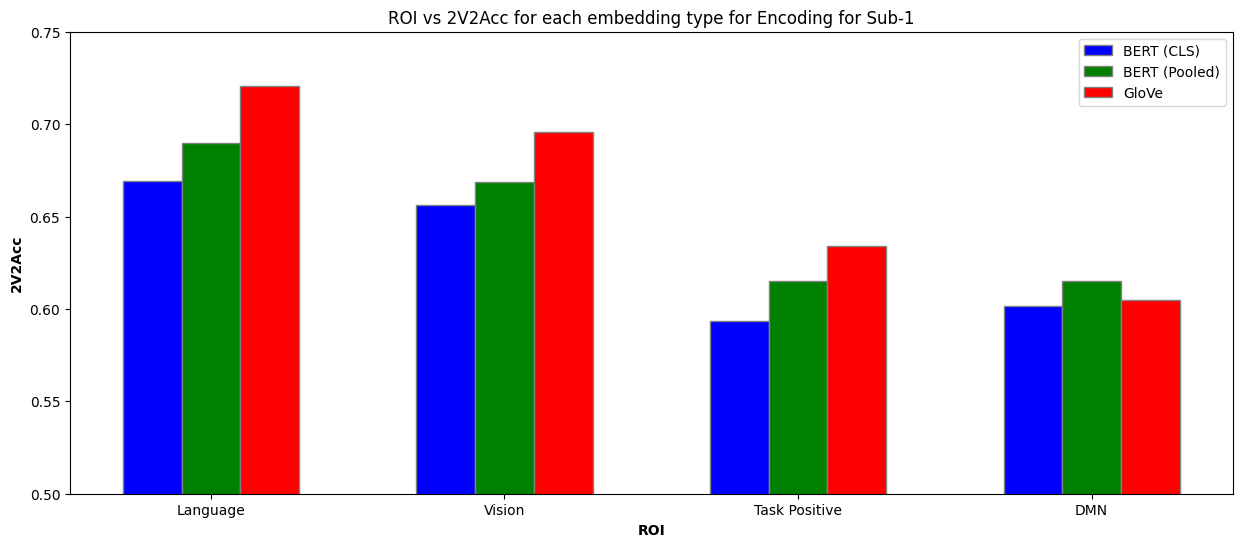

In [320]:
groups = ['Language', 'Vision', 'Task Positive', 'DMN']
cases = ['BERT (CLS)', 'BERT (Pooled)', 'GloVe']
metrics=subj1_2v2_lst_enc
bar_width = 0.2
r1 = np.arange(len(groups))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]
plt.figure(figsize=(15, 6))
plt.bar(r1, [metrics[0],metrics[3],metrics[6],metrics[9]], color='b', width=bar_width, edgecolor='grey', label=cases[0])
plt.bar(r2, [metrics[1],metrics[4],metrics[7],metrics[10]], color='g', width=bar_width, edgecolor='grey', label=cases[1])
plt.bar(r3, [metrics[2],metrics[5],metrics[8],metrics[11]], color='r', width=bar_width, edgecolor='grey', label=cases[2])
plt.xlabel('ROI', fontweight='bold')
plt.ylabel('2V2Acc', fontweight='bold')
plt.ylim(0.5,0.75)
plt.title('ROI vs 2V2Acc for each embedding type for Encoding for Sub-1')
plt.xticks([r + bar_width for r in range(len(groups))], groups)
plt.legend()
plt.show()

#### Bar plot for ROI vs mean PC across folds for 3 types of embeddings for subject-1 for Encoding

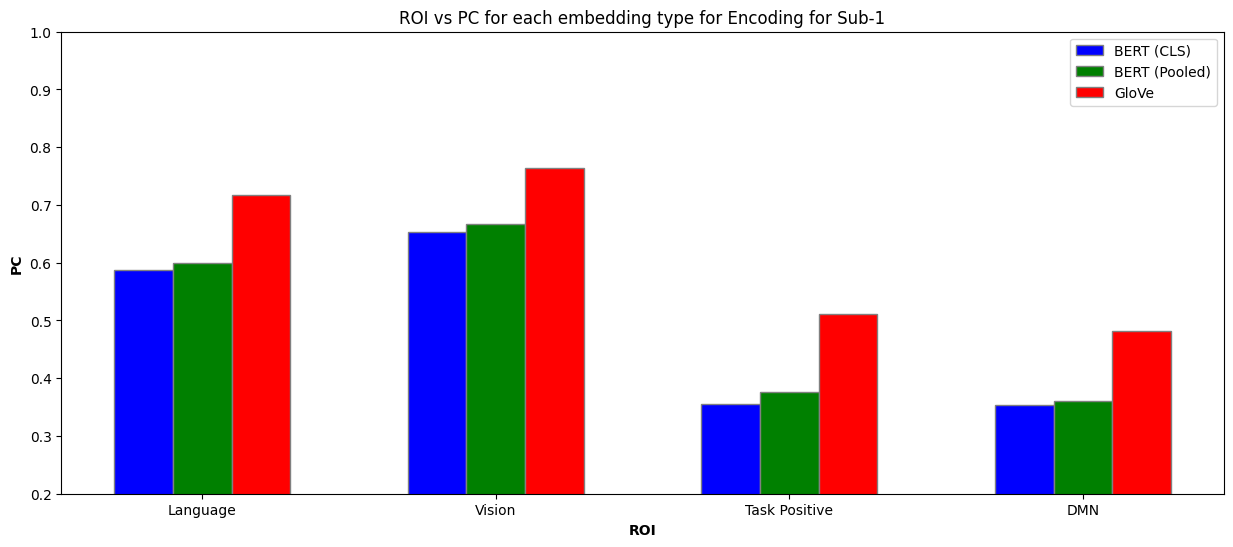

In [297]:
groups = ['Language', 'Vision', 'Task Positive', 'DMN']
cases = ['BERT (CLS)', 'BERT (Pooled)', 'GloVe']
metrics=subj1_pc_lst_enc
bar_width = 0.2
r1 = np.arange(len(groups))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]
plt.figure(figsize=(15, 6))
plt.bar(r1, [metrics[0],metrics[3],metrics[6],metrics[9]], color='b', width=bar_width, edgecolor='grey', label=cases[0])
plt.bar(r2, [metrics[1],metrics[4],metrics[7],metrics[10]], color='g', width=bar_width, edgecolor='grey', label=cases[1])
plt.bar(r3, [metrics[2],metrics[5],metrics[8],metrics[11]], color='r', width=bar_width, edgecolor='grey', label=cases[2])
plt.xlabel('ROI', fontweight='bold')
plt.ylabel('PC', fontweight='bold')
plt.ylim(0.2,1)
plt.title('ROI vs PC for each embedding type for Encoding for Sub-1')
plt.xticks([r + bar_width for r in range(len(groups))], groups)
plt.legend()
plt.show()

#### Bar plot for ROI vs mean 2V2Acc across folds for 3 types of embeddings for subject-1 for Decoding

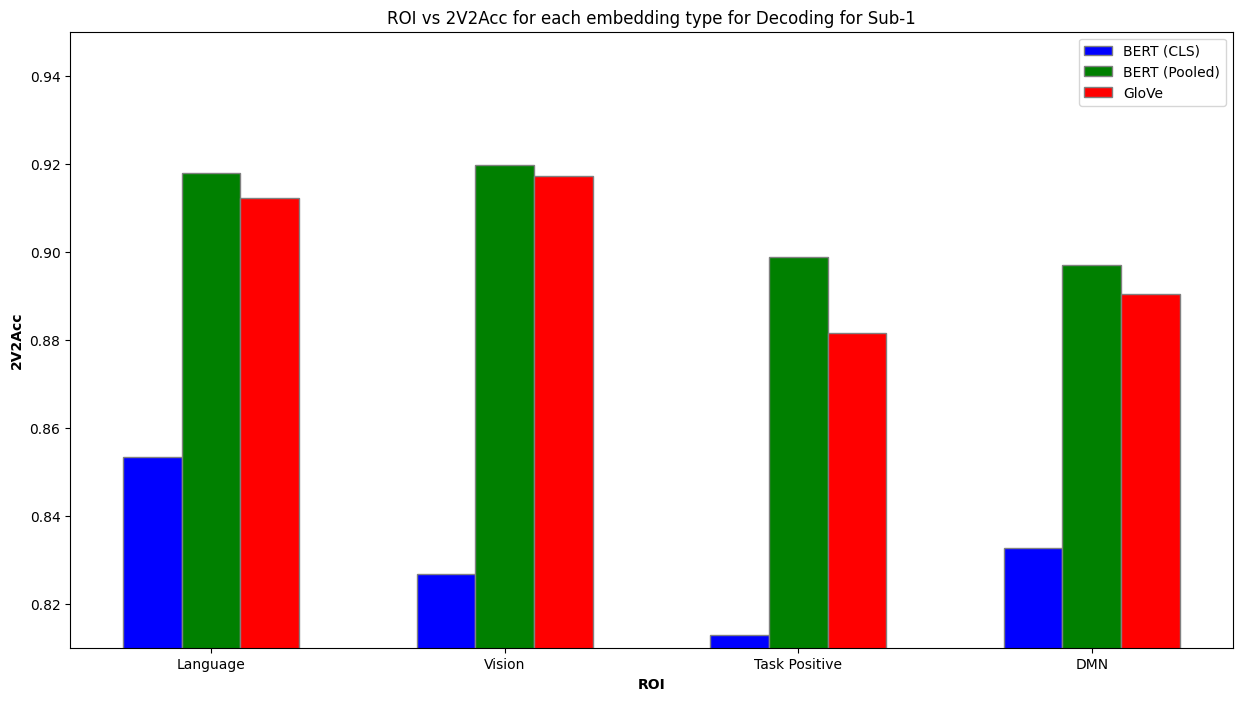

In [330]:
groups = ['Language', 'Vision', 'Task Positive', 'DMN']
cases = ['BERT (CLS)', 'BERT (Pooled)', 'GloVe']
metrics=subj1_2v2_lst_dec
bar_width = 0.2
r1 = np.arange(len(groups))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]
plt.figure(figsize=(15, 8))
plt.bar(r1, [metrics[0],metrics[3],metrics[6],metrics[9]], color='b', width=bar_width, edgecolor='grey', label=cases[0])
plt.bar(r2, [metrics[1],metrics[4],metrics[7],metrics[10]], color='g', width=bar_width, edgecolor='grey', label=cases[1])
plt.bar(r3, [metrics[2],metrics[5],metrics[8],metrics[11]], color='r', width=bar_width, edgecolor='grey', label=cases[2])
plt.xlabel('ROI', fontweight='bold')
plt.ylabel('2V2Acc', fontweight='bold')
plt.ylim(0.81,0.95)
plt.title('ROI vs 2V2Acc for each embedding type for Decoding for Sub-1')
plt.xticks([r + bar_width for r in range(len(groups))], groups)
plt.legend()
plt.show()

#### Bar plot for ROI vs mean PC across folds for 3 types of embeddings for subject-1 for Decoding

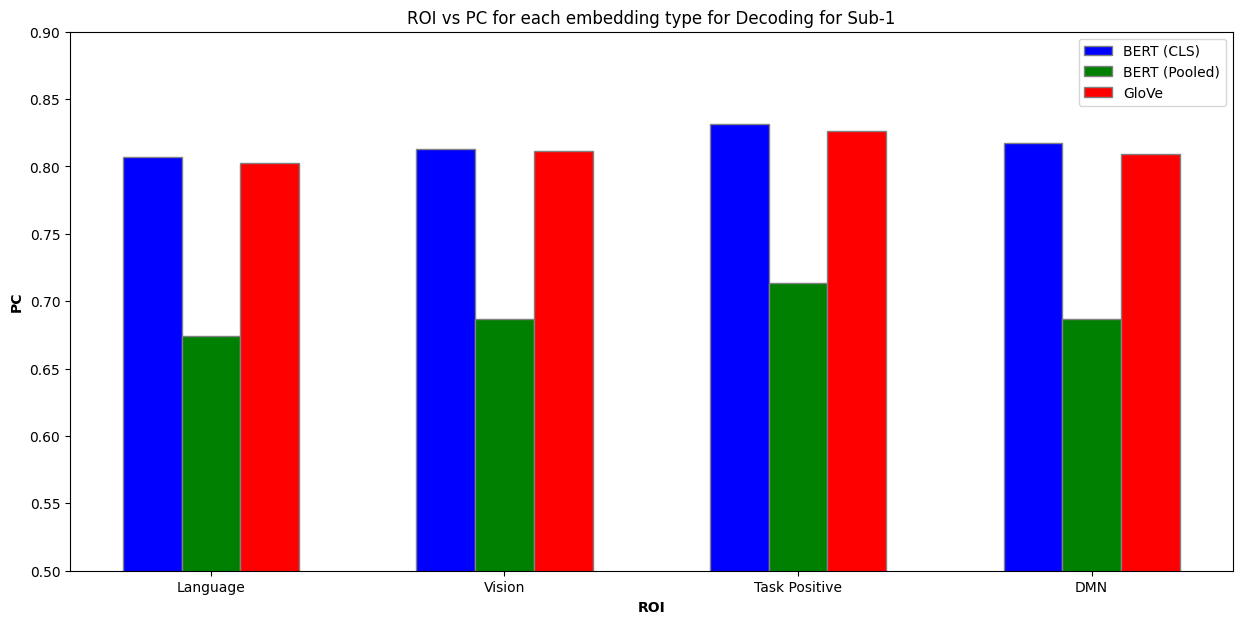

In [333]:
groups = ['Language', 'Vision', 'Task Positive', 'DMN']
cases = ['BERT (CLS)', 'BERT (Pooled)', 'GloVe']
metrics=subj1_pc_lst_dec
bar_width = 0.2
r1 = np.arange(len(groups))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]
plt.figure(figsize=(15, 7))
plt.bar(r1, [metrics[0],metrics[3],metrics[6],metrics[9]], color='b', width=bar_width, edgecolor='grey', label=cases[0])
plt.bar(r2, [metrics[1],metrics[4],metrics[7],metrics[10]], color='g', width=bar_width, edgecolor='grey', label=cases[1])
plt.bar(r3, [metrics[2],metrics[5],metrics[8],metrics[11]], color='r', width=bar_width, edgecolor='grey', label=cases[2])
plt.xlabel('ROI', fontweight='bold')
plt.ylabel('PC', fontweight='bold')
plt.ylim(0.5,0.9)
plt.title('ROI vs PC for each embedding type for Decoding for Sub-1')
plt.xticks([r + bar_width for r in range(len(groups))], groups)
plt.legend()
plt.show()

## Subject-2

In [300]:
subj2_data=np.load('data/subj2.npy', allow_pickle=True).item()
subj2_language=subj2_data['language']
subj2_vision=subj2_data['vision']
subj2_task=subj2_data['task']
subj2_dmn=subj2_data['dmn']
subj2_2v2_lst_enc=[]
subj2_pc_lst_enc=[]
subj2_2v2_lst_dec=[]
subj2_pc_lst_dec=[]

### ROI: Language

#### BERT (CLS)

In [301]:
encode_decode(glove_embeddings.shape[0],k,subj2_language,bert_embeddings_cls,'Language','BERT (CLS)',2,subj2_2v2_lst_enc,subj2_pc_lst_enc,subj2_2v2_lst_dec,subj2_pc_lst_dec)

Subject-2
Encoding brain voxels...
ROI: Language, Embeddings: BERT (CLS)
2V2Acc: 0.6214603174603175
PC: 0.40428097301321453

Subject-2
Decoding sentence representations...
ROI: Language, Embeddings: BERT (CLS)
2V2Acc: 0.808039001576416
PC: 0.7925856314340113


#### BERT (Pooled)

In [302]:
encode_decode(glove_embeddings.shape[0],k,subj2_language,bert_embeddings_pooled,'Language','BERT (Pooled)',2,subj2_2v2_lst_enc,subj2_pc_lst_enc,subj2_2v2_lst_dec,subj2_pc_lst_dec)

Subject-2
Encoding brain voxels...
ROI: Language, Embeddings: BERT (Pooled)
2V2Acc: 0.6553232587862001
PC: 0.4158266447118336

Subject-2
Decoding sentence representations...
ROI: Language, Embeddings: BERT (Pooled)
2V2Acc: 0.8899771335034734
PC: 0.6569936588609291


#### GloVe

In [303]:
encode_decode(glove_embeddings.shape[0],k,subj2_language,glove_embeddings,'Language','GloVe',2,subj2_2v2_lst_enc,subj2_pc_lst_enc,subj2_2v2_lst_dec,subj2_pc_lst_dec)

Subject-2
Encoding brain voxels...
ROI: Language, Embeddings: GloVe
2V2Acc: 0.6661125746378478
PC: 0.53656263373609

Subject-2
Decoding sentence representations...
ROI: Language, Embeddings: GloVe
2V2Acc: 0.8913664340344555
PC: 0.7890162171960432


### ROI: Vision

#### BERT (CLS)

In [304]:
encode_decode(glove_embeddings.shape[0],k,subj2_vision,bert_embeddings_cls,'Vision','BERT (CLS)',2,subj2_2v2_lst_enc,subj2_pc_lst_enc,subj2_2v2_lst_dec,subj2_pc_lst_dec)

Subject-2
Encoding brain voxels...
ROI: Vision, Embeddings: BERT (CLS)
2V2Acc: 0.6153783809281904
PC: 0.6078695637068424

Subject-2
Decoding sentence representations...
ROI: Vision, Embeddings: BERT (CLS)
2V2Acc: 0.8082047647269899
PC: 0.7999345142809742


#### BERT (Pooled)

In [305]:
encode_decode(glove_embeddings.shape[0],k,subj2_vision,bert_embeddings_pooled,'Vision','BERT (Pooled)',2,subj2_2v2_lst_enc,subj2_pc_lst_enc,subj2_2v2_lst_dec,subj2_pc_lst_dec)

Subject-2
Encoding brain voxels...
ROI: Vision, Embeddings: BERT (Pooled)
2V2Acc: 0.6484062105140083
PC: 0.6198473529515175

Subject-2
Decoding sentence representations...
ROI: Vision, Embeddings: BERT (Pooled)
2V2Acc: 0.8975451100870455
PC: 0.6683842502707049


#### GloVe

In [306]:
encode_decode(glove_embeddings.shape[0],k,subj2_vision,glove_embeddings,'Vision','GloVe',2,subj2_2v2_lst_enc,subj2_pc_lst_enc,subj2_2v2_lst_dec,subj2_pc_lst_dec)

Subject-2
Encoding brain voxels...
ROI: Vision, Embeddings: GloVe
2V2Acc: 0.6740631904882857
PC: 0.7283763409357914

Subject-2
Decoding sentence representations...
ROI: Vision, Embeddings: GloVe
2V2Acc: 0.8847955037878329
PC: 0.7968582641606201


### ROI: Task Positive

#### BERT (CLS)

In [307]:
encode_decode(glove_embeddings.shape[0],k,subj2_task,bert_embeddings_cls,'Task Positive','BERT (CLS)',2,subj2_2v2_lst_enc,subj2_pc_lst_enc,subj2_2v2_lst_dec,subj2_pc_lst_dec)

Subject-2
Encoding brain voxels...
ROI: Task Positive, Embeddings: BERT (CLS)
2V2Acc: 0.5419331002979466
PC: 0.21090953723314493

Subject-2
Decoding sentence representations...
ROI: Task Positive, Embeddings: BERT (CLS)
2V2Acc: 0.77351116916837
PC: 0.8121941430246311


#### BERT (Pooled)

In [308]:
encode_decode(glove_embeddings.shape[0],k,subj2_task,bert_embeddings_pooled,'Task Positive','BERT (Pooled)',2,subj2_2v2_lst_enc,subj2_pc_lst_enc,subj2_2v2_lst_dec,subj2_pc_lst_dec)

Subject-2
Encoding brain voxels...
ROI: Task Positive, Embeddings: BERT (Pooled)
2V2Acc: 0.5760605827497369
PC: 0.22096162334158417

Subject-2
Decoding sentence representations...
ROI: Task Positive, Embeddings: BERT (Pooled)
2V2Acc: 0.8574890300002822
PC: 0.6853862769459322


#### Glove

In [309]:
encode_decode(glove_embeddings.shape[0],k,subj2_task,glove_embeddings,'Task Positive','GloVe',2,subj2_2v2_lst_enc,subj2_pc_lst_enc,subj2_2v2_lst_dec,subj2_pc_lst_dec)

Subject-2
Encoding brain voxels...
ROI: Task Positive, Embeddings: GloVe
2V2Acc: 0.5670254863303378
PC: 0.3266099897488642

Subject-2
Decoding sentence representations...
ROI: Task Positive, Embeddings: GloVe
2V2Acc: 0.845387223371272
PC: 0.8073603918289752


### ROI: DMN

#### BERT (CLS)

In [310]:
encode_decode(glove_embeddings.shape[0],k,subj2_dmn,bert_embeddings_cls,'DMN','BERT (CLS)',2,subj2_2v2_lst_enc,subj2_pc_lst_enc,subj2_2v2_lst_dec,subj2_pc_lst_dec)

Subject-2
Encoding brain voxels...
ROI: DMN, Embeddings: BERT (CLS)
2V2Acc: 0.5597035306070612
PC: 0.2617141794942162

Subject-2
Decoding sentence representations...
ROI: DMN, Embeddings: BERT (CLS)
2V2Acc: 0.776591051924961
PC: 0.7943245527162949


#### BERT (Pooled)

In [311]:
encode_decode(glove_embeddings.shape[0],k,subj2_dmn,bert_embeddings_pooled,'DMN','BERT (Pooled)',2,subj2_2v2_lst_enc,subj2_pc_lst_enc,subj2_2v2_lst_dec,subj2_pc_lst_dec)

Subject-2
Encoding brain voxels...
ROI: DMN, Embeddings: BERT (Pooled)
2V2Acc: 0.6070014183710908
PC: 0.2894260672277705

Subject-2
Decoding sentence representations...
ROI: DMN, Embeddings: BERT (Pooled)
2V2Acc: 0.8748330039390237
PC: 0.6618432799367486


#### GloVe

In [312]:
encode_decode(glove_embeddings.shape[0],k,subj2_dmn,glove_embeddings,'DMN','GloVe',2,subj2_2v2_lst_enc,subj2_pc_lst_enc,subj2_2v2_lst_dec,subj2_pc_lst_dec)

Subject-2
Encoding brain voxels...
ROI: DMN, Embeddings: GloVe
2V2Acc: 0.6070419971697086
PC: 0.3986060551488129

Subject-2
Decoding sentence representations...
ROI: DMN, Embeddings: GloVe
2V2Acc: 0.8368809092411837
PC: 0.7863687792315552


### Bar Graphs for Results

#### Bar plot for ROI vs mean 2V2Acc across folds for 3 types of embeddings for subject-2 for Encoding

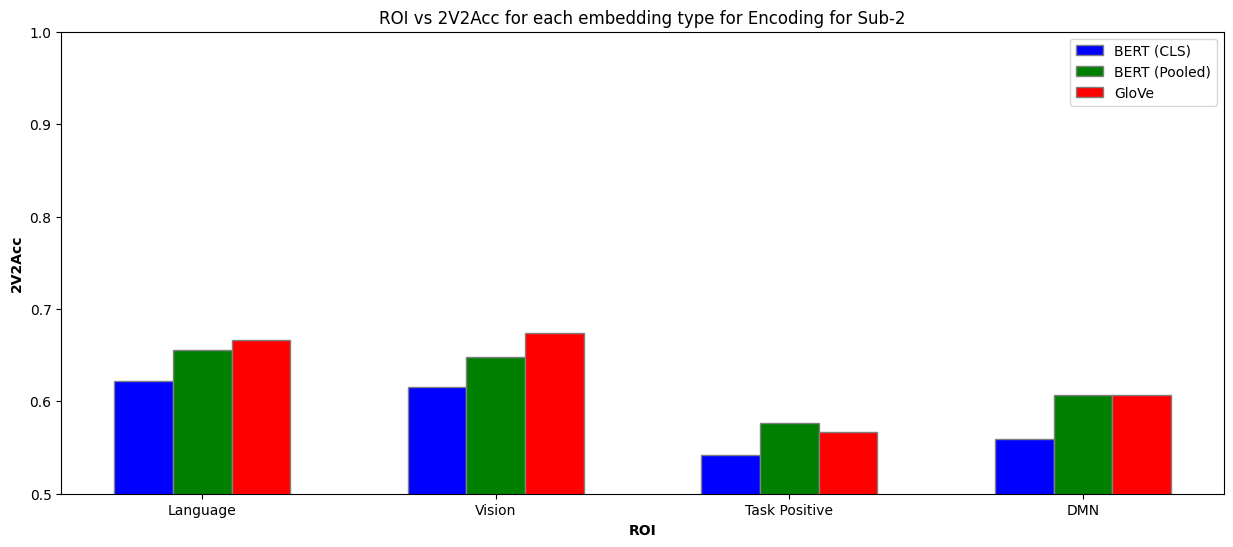

In [313]:
groups = ['Language', 'Vision', 'Task Positive', 'DMN']
cases = ['BERT (CLS)', 'BERT (Pooled)', 'GloVe']
metrics=subj2_2v2_lst_enc
bar_width = 0.2
r1 = np.arange(len(groups))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]
plt.figure(figsize=(15, 6))
plt.bar(r1, [metrics[0],metrics[3],metrics[6],metrics[9]], color='b', width=bar_width, edgecolor='grey', label=cases[0])
plt.bar(r2, [metrics[1],metrics[4],metrics[7],metrics[10]], color='g', width=bar_width, edgecolor='grey', label=cases[1])
plt.bar(r3, [metrics[2],metrics[5],metrics[8],metrics[11]], color='r', width=bar_width, edgecolor='grey', label=cases[2])
plt.xlabel('ROI', fontweight='bold')
plt.ylabel('2V2Acc', fontweight='bold')
plt.ylim(0.5,1)
plt.title('ROI vs 2V2Acc for each embedding type for Encoding for Sub-2')
plt.xticks([r + bar_width for r in range(len(groups))], groups)
plt.legend()
plt.show()

#### Bar plot for ROI vs mean PC across folds for 3 types of embeddings for subject-2 for Encoding

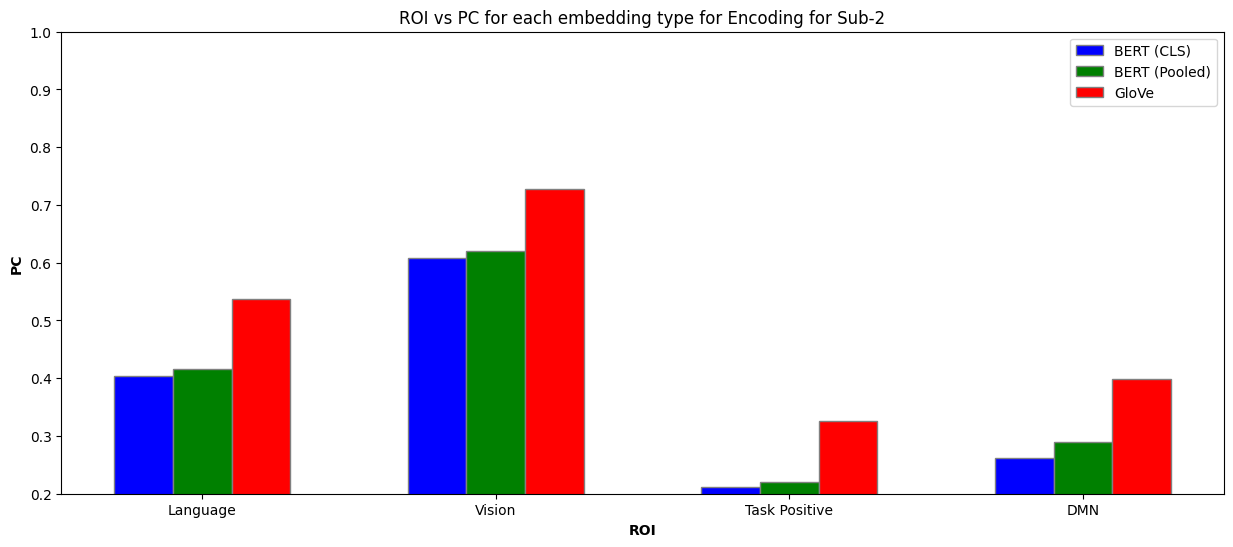

In [314]:
groups = ['Language', 'Vision', 'Task Positive', 'DMN']
cases = ['BERT (CLS)', 'BERT (Pooled)', 'GloVe']
metrics=subj2_pc_lst_enc
bar_width = 0.2
r1 = np.arange(len(groups))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]
plt.figure(figsize=(15, 6))
plt.bar(r1, [metrics[0],metrics[3],metrics[6],metrics[9]], color='b', width=bar_width, edgecolor='grey', label=cases[0])
plt.bar(r2, [metrics[1],metrics[4],metrics[7],metrics[10]], color='g', width=bar_width, edgecolor='grey', label=cases[1])
plt.bar(r3, [metrics[2],metrics[5],metrics[8],metrics[11]], color='r', width=bar_width, edgecolor='grey', label=cases[2])
plt.xlabel('ROI', fontweight='bold')
plt.ylabel('PC', fontweight='bold')
plt.ylim(0.2,1)
plt.title('ROI vs PC for each embedding type for Encoding for Sub-2')
plt.xticks([r + bar_width for r in range(len(groups))], groups)
plt.legend()
plt.show()

#### Bar plot for ROI vs mean 2V2Acc across folds for 3 types of embeddings for subject-2 for Decoding

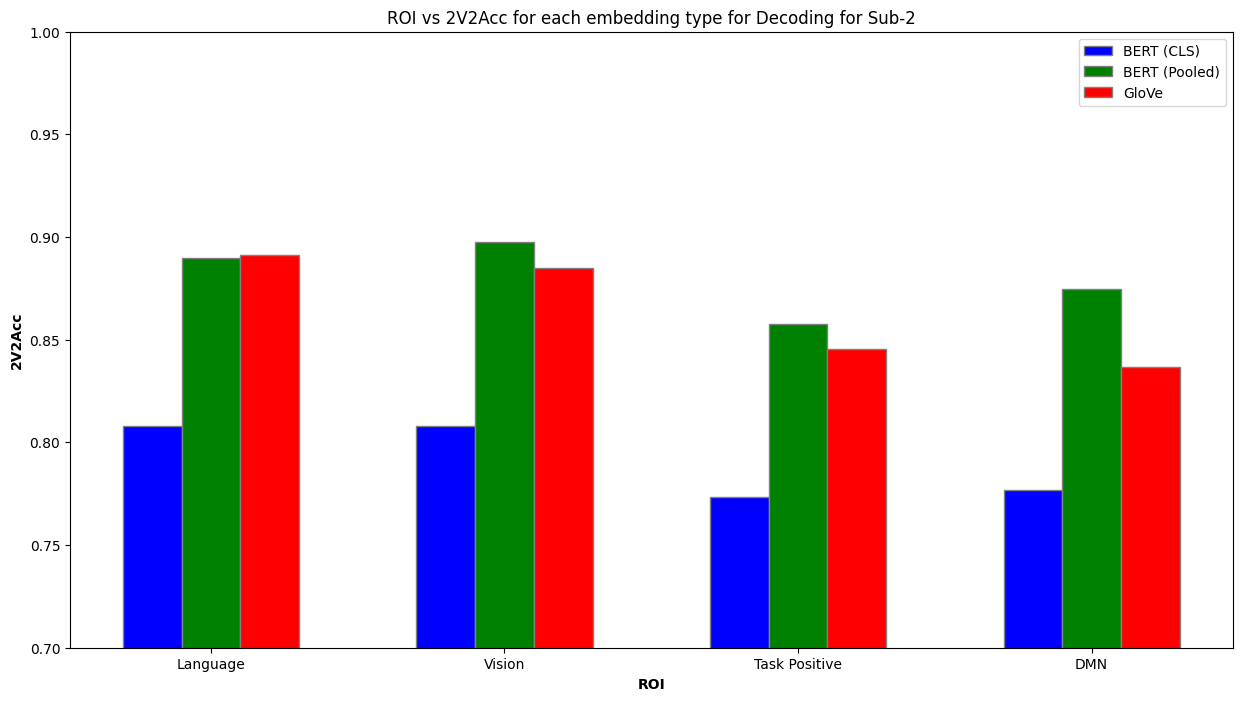

In [334]:
groups = ['Language', 'Vision', 'Task Positive', 'DMN']
cases = ['BERT (CLS)', 'BERT (Pooled)', 'GloVe']
metrics=subj2_2v2_lst_dec
bar_width = 0.2
r1 = np.arange(len(groups))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]
plt.figure(figsize=(15, 8))
plt.bar(r1, [metrics[0],metrics[3],metrics[6],metrics[9]], color='b', width=bar_width, edgecolor='grey', label=cases[0])
plt.bar(r2, [metrics[1],metrics[4],metrics[7],metrics[10]], color='g', width=bar_width, edgecolor='grey', label=cases[1])
plt.bar(r3, [metrics[2],metrics[5],metrics[8],metrics[11]], color='r', width=bar_width, edgecolor='grey', label=cases[2])
plt.xlabel('ROI', fontweight='bold')
plt.ylabel('2V2Acc', fontweight='bold')
plt.ylim(0.7,1)
plt.title('ROI vs 2V2Acc for each embedding type for Decoding for Sub-2')
plt.xticks([r + bar_width for r in range(len(groups))], groups)
plt.legend()
plt.show()

#### Bar plot for ROI vs mean PC across folds for 3 types of embeddings for subject-2 for Decoding

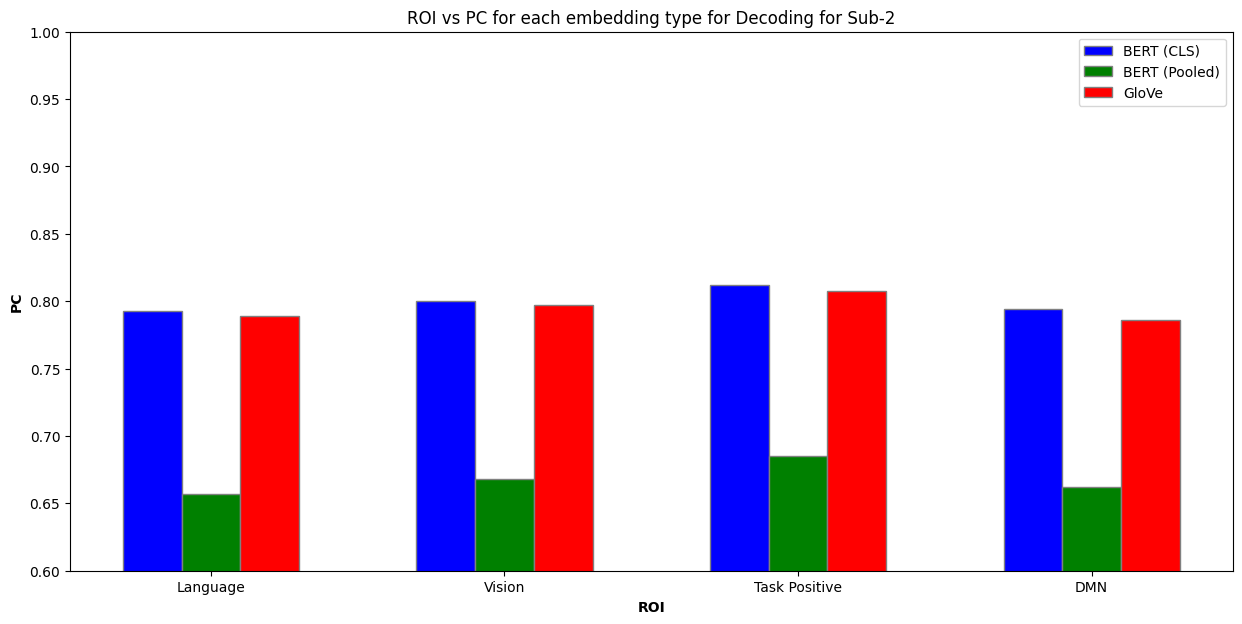

In [336]:
groups = ['Language', 'Vision', 'Task Positive', 'DMN']
cases = ['BERT (CLS)', 'BERT (Pooled)', 'GloVe']
metrics=subj2_pc_lst_dec
bar_width = 0.2
r1 = np.arange(len(groups))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]
plt.figure(figsize=(15, 7))
plt.bar(r1, [metrics[0],metrics[3],metrics[6],metrics[9]], color='b', width=bar_width, edgecolor='grey', label=cases[0])
plt.bar(r2, [metrics[1],metrics[4],metrics[7],metrics[10]], color='g', width=bar_width, edgecolor='grey', label=cases[1])
plt.bar(r3, [metrics[2],metrics[5],metrics[8],metrics[11]], color='r', width=bar_width, edgecolor='grey', label=cases[2])
plt.xlabel('ROI', fontweight='bold')
plt.ylabel('PC', fontweight='bold')
plt.ylim(0.6,1)
plt.title('ROI vs PC for each embedding type for Decoding for Sub-2')
plt.xticks([r + bar_width for r in range(len(groups))], groups)
plt.legend()
plt.show()